Deep Convolutional Generative Adversarial Network from scratch + evaluation metrics <br>
This demo is inspired by the official Tensorflow Tutorial on DCGAN's

# PREPARATION

In [1]:
# Remember to mount drive in Google Collab prior to navigating directory
%cd /content/drive/MyDrive/Github/DCGAN\ Evaluation
%ls

# NOTEBOOK SETTINGS: either choose mnist as your dataset or quickdraw and a respective category
DATASET = "mnist" 
DATASET = "quickdraw"
CATEGORY = 'tree'

# HYPERPARAMETER 1
IMG_DIR = f"npy_files_{DATASET}"
N_TRAIN = 10000
N_TEST = 2000
BUFFER_SIZE = 60000
BATCH_SIZE = 256

/content/drive/MyDrive/Github/DCGAN Evaluation
DCGAN00.ipynb  DCGAN3.ipynb  npy_files_quickdraw/  Weights_folder_temp/
DCGAN2.ipynb   DCGAN.ipynb   Weights_folder/


In [2]:
# Imports
import glob, os, urllib, itertools
import numpy as np
from scipy.stats import entropy
from scipy.linalg import sqrtm
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, ReLU, LeakyReLU, Dropout
import matplotlib.pyplot as plt
import PIL
import pylab as pl
import imageio
from IPython import display
import time


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    #Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    tf.config.set_logical_device_configuration(
      gpus[0],
      [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    #Virtual devices must be set before GPUs have been initialized
    print(e)

"""Image generation for training visualization"""
def generate_image(model) :  
    test_input = tf.random.normal([1, 100])
    prediction = model(test_input, training=False)
    for i in range(prediction.shape[0]):
        pl.imshow(prediction[i, :, :, 0] * 127.5 + 127.5)
        display.clear_output(wait=True)
        display.display(pl.gcf())
    return prediction

"""Data pipeline"""
@tf.function
def prepare_data(ds):
    #Uint8 to float32
    ds = ds.map(lambda img: (tf.cast(img, tf.float32)))
    #Reshape flattened image vectors 
    ds = ds.map(lambda img: (tf.reshape(img, (28, 28, -1))))
    #Sloppy input normalization, [0, 255] to [-1, 1] (standart normal (gaussian) distribution)
    ds = ds.map(lambda img: ((img-127.5)/127.5))
    #Cache progress ("deterministic"?)
    ds = ds.cache()
    #Shuffle, batch, prefetch
    ds = ds.shuffle(BUFFER_SIZE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(100)
    #return preprocessed dataset
    return ds

144721 images to train on of shape (28, 28, 1)


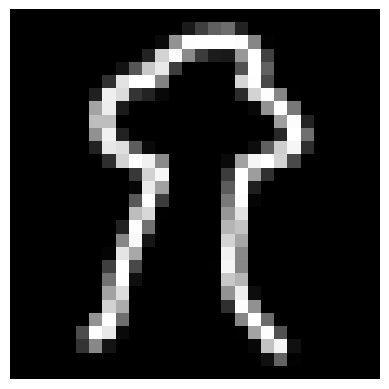

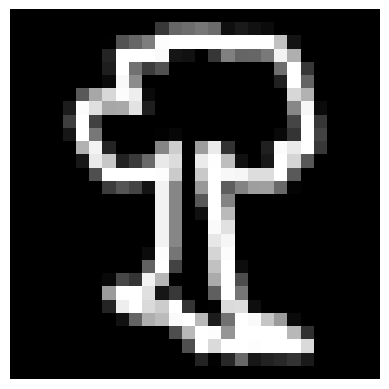

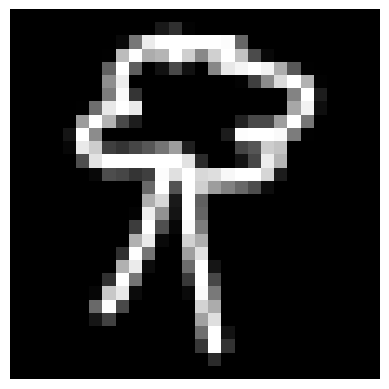

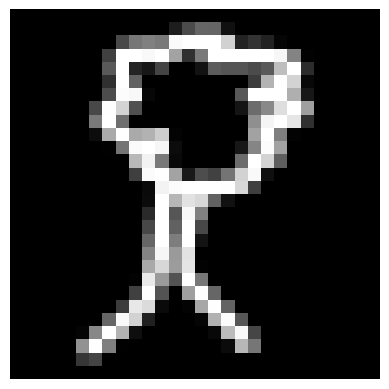

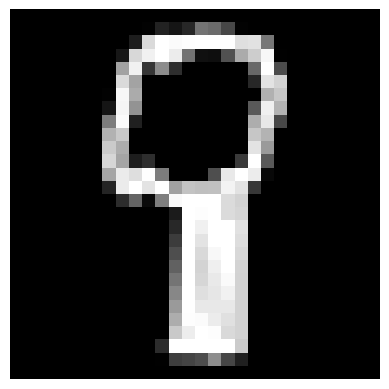

In [3]:
"""IMAGES""" 
if DATASET == "quickdraw":
    #QUICKDRAW - DATASET
    categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
    if not os.path.isdir(IMG_DIR):
      os.mkdir(IMG_DIR)
    #Select Category of images to train on and load data :
    url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{CATEGORY}.npy'  
    urllib.request.urlretrieve(url, f'{IMG_DIR}/{CATEGORY}.npy')
    images = np.load(f'{IMG_DIR}/{CATEGORY}.npy')
    img_shape = [28,28,1]
    #You can limit the amount of images you use for training by setting :
    train_images = images[:N_TRAIN]
    test_images = images[N_TRAIN: N_TRAIN+N_TEST]
    train_ds = tf.data.Dataset.from_tensor_slices(train_images)
    test_ds = tf.data.Dataset.from_tensor_slices(test_images)

elif DATASET == "mnist":
    (train_ds, test_ds), ds_info = tfds.load("mnist", split=['train', 'test'], as_supervised=True, with_info=True)
    train_ds = train_ds.map(lambda img, target: img)
    test_ds = test_ds.map(lambda img, target: img)

"""INSPECT IMAGES"""
temp = test_ds.take(5)
temp = temp.map(lambda image: (tf.cast(tf.reshape(image, img_shape), tf.float32)))
# print("Quickdraw categories: ", categories[:10])
print(f'{len(images)} images to train on of shape {tf.reshape(images[0], img_shape).shape}')
for elem in temp:
    plt.gray()
    plt.imshow(elem[:,:,0])
    plt.axis('off')
    plt.show()

"""DATASETS"""
train_dataset = train_ds.apply(prepare_data)
test_dataset = test_ds.apply(prepare_data)

# MODEL

In [8]:
# HYPERPARAMETER 2

DROPOUT_RATE = 0.1
LEARNING_RATE = 1e-3
LOSS_NORMALISATION = True
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=LOSS_NORMALISATION)
noise_dim = 100
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(2*LEARNING_RATE)

EPOCHS = 5
STEPS = 1   ### To control length of an epoch
PATH_SAVE_G = 'Weights_folder_temp/Weights_Generator'
PATH_SAVE_D = 'Weights_folder_temp/Weights_Discriminator'

In [9]:
class Discriminator(tf.keras.models.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = [
            Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
            LeakyReLU(),
            BatchNormalization(),
            Dropout(DROPOUT_RATE),
            Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
            LeakyReLU(),
            Dropout(DROPOUT_RATE),
            Flatten()]
        if LOSS_NORMALISATION:
            self.discriminator.append(Dense(1, activation='sigmoid'))
        else:
            self.discriminator.append(Dense(1))
    @tf.function
    def call(self, x, training=True):
        for layer in self.discriminator:
            x = layer(x, training=training)
        return x

class Generator(tf.keras.models.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = [
            Dense(7*7*256, use_bias=False, input_shape=(100,)),
            BatchNormalization(),
            LeakyReLU(),
            Reshape((7, 7, 256)),   ### output_shape (None, 7, 7, 256), None is the batch size
            Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),   ### output_shape (None, 7, 7, 128)
            BatchNormalization(),
            LeakyReLU(),
            Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),   ### output_shape (None, 14, 14, 64)
            BatchNormalization(),
            LeakyReLU(),
            Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')]   ### output_shape (None, 28, 28, 1)
    @tf.function
    def call(self, x, training=True) :
        for layer in self.generator:
            x = layer(x, training=training)
        return x

def discriminator_loss(real_output, fake_output):
    real_loss = BCE(tf.ones_like(real_output), real_output)
    fake_loss = BCE(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return BCE(tf.ones_like(fake_output), fake_output)

generator = Generator()
discriminator = Discriminator()

# TRAINING
Either train DCGAN from scratch OR load the pretrained model by executing the "LOAD MODEL" cell first...

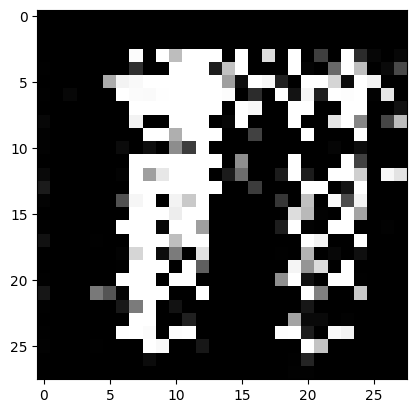

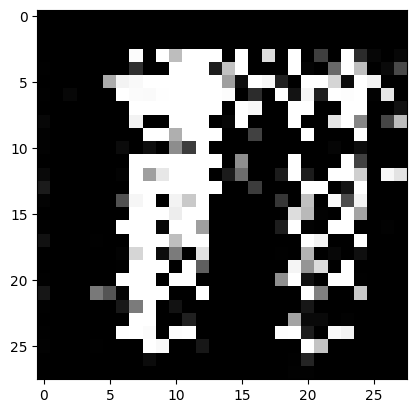

In [11]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape:
        with tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
            real_output = discriminator(images, training=True)
            fake_output = discriminator(generated_images, training=True)
            gen_loss = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs, steps_per_epoch):
    for epoch in range(epochs):
      print(f"-> Entering epoch: {epoch+1}/{epochs}")
      start = time.time()
      # Limit the number of training steps per epoch
      limited_dataset = itertools.islice(dataset, steps_per_epoch)
      for step, image_batch in enumerate(limited_dataset):
          print(f"Step: {step+1}/{steps_per_epoch}")
          train_step(image_batch)
      # Show generated images                                              
      generate_image(generator)  
      # Save the model every 15 epochs
      if (epoch + 1) % 10 == 0:
          generator.save_weights(PATH_SAVE_G)
          print("Generator saved in file: %s" % PATH_SAVE_G)
          discriminator.save_weights(PATH_SAVE_D)
          print("Discriminator saved in file: %s" % PATH_SAVE_D)

tf.keras.backend.clear_session()
train(train_dataset, EPOCHS, STEPS)

### LOAD MODEL

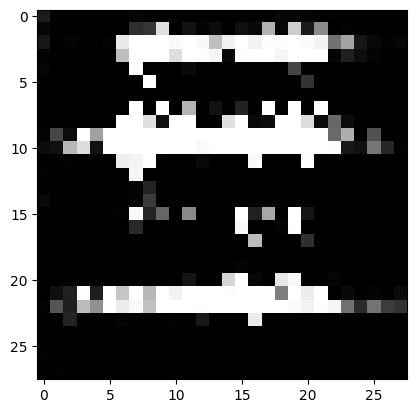


Generated image shape:  (1, 28, 28, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
Decision: 1.0


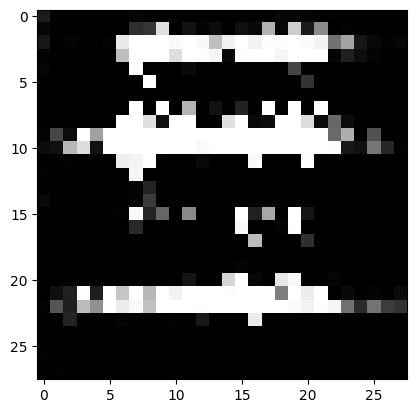

In [20]:
from scipy.stats import entropy
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

PATH_LOAD_G = 'Weights_folder/Weights_Generator'
PATH_LOAD_D = 'Weights_folder/Weights_Discriminator'
generator = Generator()
generator.load_weights(PATH_LOAD_G)
discriminator = Discriminator()
discriminator.load_weights(PATH_LOAD_D)

for i in range(10):
    #test generator
    generated_image = generate_image(generator) 
    print("\nGenerated image shape: ", generated_image.shape, type(generated_image))
    #test discriminato
    decision = discriminator(generated_image)
    print(f"Decision: {float(decision)}")   ### \nOutput positive values for real images, and negative values for fake images
    time.sleep(1)

# EVALUATION

1.   Generate real and fake samples of fixed size
2.   Scale images to at least (75 x 75 x 3), minimum required dimensionality for feauture extraction by InceptionV3
3. Normalize feature vectors 
4. Compute KL, JS, KID, FID and compare for different model states
5. Identify convergence issues of DCGAN after approx. 50 epochs 





In [21]:
N_IMAGES = 1000

def sample_images(generator, n_images):
  noise = tf.random.normal([n_images, 100])
  generated_images = generator(noise, training=False)
  return generated_images

def upscale_images(images, target_size):
    upscaled_images = []
    for image in images:
        upscaled_image = tf.image.resize(image, target_size, method=tf.image.ResizeMethod.BILINEAR)
        upscaled_images.append(upscaled_image)
    upscaled_images = tf.concat(upscaled_images, axis=0)
    upscaled_images = tf.repeat(upscaled_images, 3, axis=-1)
    upscaled_images = tf.reshape(upscaled_images, (-1, target_size[0], target_size[1], 3))
    return upscaled_images

fakes = sample_images(generator, N_IMAGES).numpy()
fakes = upscale_images(fakes, (75, 75))
reals = test_images[:N_IMAGES]
reals = np.reshape(reals, (1000, 28, 28, 1))
reals = upscale_images(reals, (75, 75))
print(reals.shape, type(reals))

I = InceptionV3(include_top=False, pooling='avg', input_shape=(75, 75, 3))   ### fakes[0,:,:,:].shape
fakes_preprocessed = preprocess_input(tf.cast(fakes, tf.float32))
reals_preprocessed = preprocess_input(tf.cast(reals, tf.float32))

fakes_features = I.predict(fakes_preprocessed)
reals_features = I.predict(reals_preprocessed)
reals_features_normalized = reals_features / np.sum(reals_features, axis=1, keepdims=True)
fakes_features_normalized = fakes_features / np.sum(fakes_features, axis=1, keepdims=True)
print(reals_features_normalized.shape, type(reals_features_normalized))

(1000, 75, 75, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>
32/32 [==============================] - 14s 436ms/step
(1000, 2048) <class 'numpy.ndarray'>


In [ ]:
# Plots rescaled images
temp = fakes[:5,:,:,:]
for elem in temp:
    plt.imshow(elem[:,:,0], cmap=None)
    plt.axis('off')
    plt.show()

In [30]:
def kl_divergence(p, q, epsilon=1e-8):
    p = np.clip(p, epsilon, 1.0)
    q = np.clip(q, epsilon, 1.0)
    return np.sum(p * np.log2(p / q))

def js_divergence(p, q, epsilon=1e-8):
    m = 0.5 * (p + q)
    kl_p = kl_divergence(p, m, epsilon)
    kl_q = kl_divergence(q, m, epsilon)
    return 0.5 * (kl_p + kl_q)

def compute_kid(real_features, generated_features):
    # Compute mean and covariance of real features
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    # Compute mean and covariance of generated features
    mu_generated = np.mean(generated_features, axis=0)
    sigma_generated = np.cov(generated_features, rowvar=False)

    # Calculate squared Euclidean distance between means
    euklidean = np.sum((mu_real - mu_generated) ** 2)
    # Calculate trace of covariance matrices
    trace_real = np.trace(sigma_real)
    trace_generated = np.trace(sigma_generated)
    # Calculate trace of product of covariance matrices
    trace_product = np.trace(np.dot(sigma_real, sigma_generated))
    # Calculate KID score
    kid_score = euklidean + trace_real + trace_generated - 2 * trace_product
    return kid_score

def calculate_fid(real_features, generated_features):
    # Compute mean and covariance of real features
    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)
    # Compute mean and covariance of generated features
    mu_generated = np.mean(generated_features, axis=0)
    sigma_generated = np.cov(generated_features, rowvar=False)

    # Calculate squared Euclidean distance between means
    distance = np.sum((mu_real - mu_generated) ** 2)
    # Calculate trace of covariance matrices
    trace_real = np.trace(sigma_real)
    trace_generated = np.trace(sigma_generated)
    # Calculate covariance matrix square root
    cov_sqrt = sqrtm(sigma_real.dot(sigma_generated)).real
    # Calculate FID score
    fid_score = distance + trace_real + trace_generated - 2 * np.trace(cov_sqrt)
    return fid_score

kl_score_real_fake = kl_divergence(reals_features_normalized, fakes_features_normalized)
kl_score_fake_real = kl_divergence(fakes_features_normalized, reals_features_normalized)
print("KL Divergence Scores \n     - Real to fake: ", kl_score_real_fake, "\n     - Fake to real: ", kl_score_fake_real)

js_score = js_divergence(reals_features_normalized, fakes_features_normalized)
print("JS Divergence Score: ", js_score)

kid = compute_kid(reals_features_normalized, fakes_features_normalized)
print("Kernel Inception Distance: ", kid)

fid = calculate_fid(reals_features_normalized, fakes_features_normalized)
print("Fréchet Inception Distance: ", np.round(fid, 5))

KL Divergence Scores 
     - Real to fake:  12574.499 
     - Fake to real:  11193.226
JS Divergence Score:  699.1343994140625
Kernel Inception Distance:  0.010156500743716792
Fréchet Inception Distance:  0.00902
